In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

<Figure size 432x288 with 0 Axes>

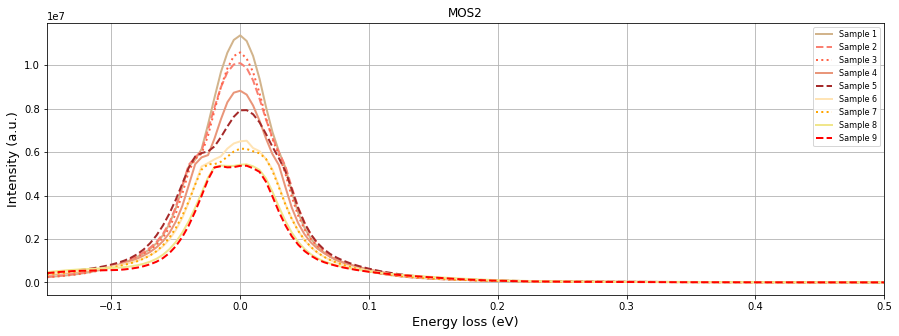

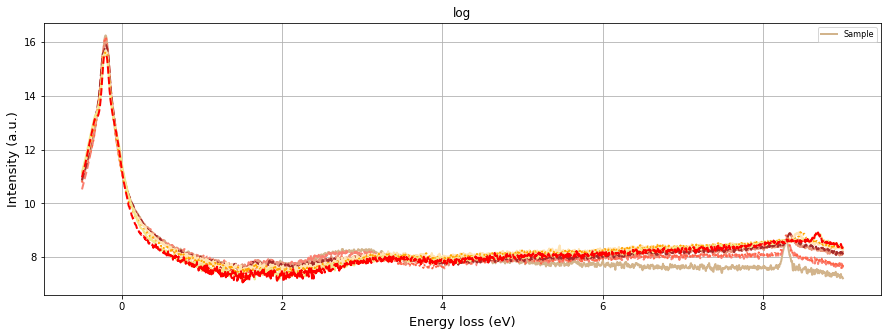

In [2]:
%run EELS-ZLP-May.py


With 1000 bins, the minimum number of training points within each bin is 9 and maximum is 18


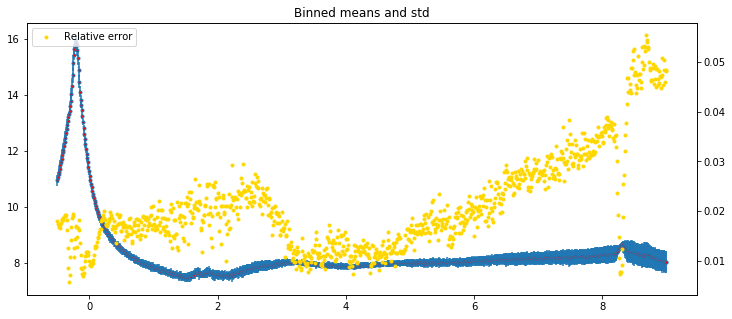

In [4]:
%run Functions.ipynb
fig = plt.gcf()

x_train = np.concatenate((x1,x2,x3,x3,x5,x6,x7,x8,x9))
logy_train = np.concatenate((log_y1, log_y2, log_y3, log_y4, log_y5, log_y6, log_y7, log_y8, log_y9))
y_train = np.concatenate((y1,y2,y3,y4,y5,y6,y7,y8,y9))
nbins = 1000
minval = min(x_train)
maxval = max(x_train)

# Store output vectors for training
df_train_log, cuts1_log, cuts2_log = ewd(x_train, logy_train, nbins)
df_train, cuts1_log, cuts2_log = ewd(x_train, y_train, nbins)
mean_log, std_log, count_log= binned_statistics(x_train, logy_train, nbins)
mean_y, std_y, count_y= binned_statistics(x_train, y_train, nbins)
variance_vector_log = vectorize_variance(x_train, logy_train, nbins)
variance_vector_y = vectorize_variance(x_train, y_train, nbins)
mean_vector_log = vectorize_mean(x_train, logy_train, nbins)
mean_vector_y = vectorize_mean(x_train, y_train, nbins)

# create one vector with (x_train, y_train, sigma_train)
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_log)), "and maximum is", int(max(count_log)))
# Create a plot of the mean & std 
plot_uncertainties(x_train, logy_train, nbins, minval, maxval)
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), np.divide(std_log, mean_log), '.', color='gold',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
fig.set_size_inches(12, 5)
plt.show()

df_x = df_train[:,0]


In [5]:
df = pd.DataFrame()

df['x'] = df_x + 0.2025 # shift to align peak with zero loss
df['y'] = mean_vector_y
df['log_y'] = np.log(mean_vector_y)
df['sigma'] = variance_vector_log

df.describe()


,x,y,log_y,sigma
count,17100.000000,1.710000e+04,17100.000000,17100.000000
mean,4.452500,8.371317e+04,8.366925,0.176589
std,2.742494,6.206728e+05,1.253209,0.081997
min,-0.295000,1.791709e+03,7.490925,0.058041
25%,2.078750,2.765366e+03,7.924928,0.120810
50%,4.452500,3.094626e+03,8.037422,0.155304
75%,6.826250,3.817289e+03,8.247296,0.215695
max,9.200000,7.978663e+06,15.892281,0.458283


### FWHM is ~0.03 eV loss. Drop data for $x > a * $FWHM



In [19]:
FWHM = max(df[df['y'] > .5 * max(df['y'])]['x'])
df_window = df[df['x'] <= 9 * FWHM]

print(FWHM*9)

0.3150000000000003


In [20]:
df_window.describe()

,x,y,log_y,sigma
count,1107.00000,1.107000e+03,1107.000000,1107.000000
mean,0.01000,1.243821e+06,12.678433,0.173835
std,0.17761,2.124961e+06,1.686671,0.059390
min,-0.29500,2.147553e+04,9.974670,0.075932
25%,-0.14500,7.916643e+04,11.279308,0.116693
50%,0.01000,2.517150e+05,12.436053,0.188737
75%,0.16500,1.027863e+06,13.842992,0.227552
max,0.31500,7.978663e+06,15.892281,0.288361


### Create pseudo data for $x > a*$ FWHM 

In [21]:
min_x = 35 * FWHM
max_x = 40 * FWHM
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': 3 * np.ones(N_pseudo), \
                    'log_y': np.log(3 * np.ones(N_pseudo)), 'sigma': .2 * np.ones(N_pseudo)})



In [22]:
#df_full = df_window

df_full = pd.concat([df_window, df_pseudo])

df_full.describe()

,x,y,log_y,sigma
count,1137.000000,1.137000e+03,1137.000000,1137.000000
mean,0.044367,1.211003e+06,12.372896,0.174525
std,0.272771,2.106179e+06,2.493484,0.058750
min,-0.295000,3.000000e+00,1.098612,0.075932
25%,-0.140000,7.885334e+04,11.275345,0.116693
50%,0.020000,2.311658e+05,12.350891,0.188881
75%,0.175000,9.901429e+05,13.805605,0.224096
max,1.400000,7.978663e+06,15.892281,0.288361


### Create architecture

In [23]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [24]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value
df_train, df_test = train_test_split(df_train_full, test_size=0.2, random_state=27)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = np.copy(df_train['log_y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = np.copy(df_test['log_y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)

predictions = make_model(x,1)

#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
    

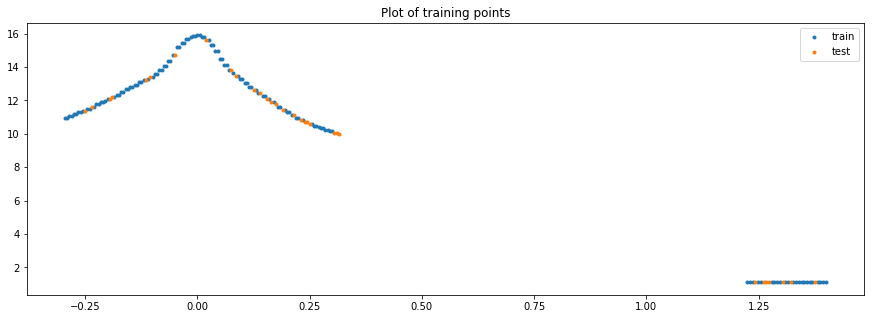

In [25]:
plt.figure(figsize=(15,5))
#plt.xlim([-0.35, -0.2])
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.title('Plot of training points')
plt.legend()

## Create MC replicas

In [26]:
### Create array of Nrep training samples

Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

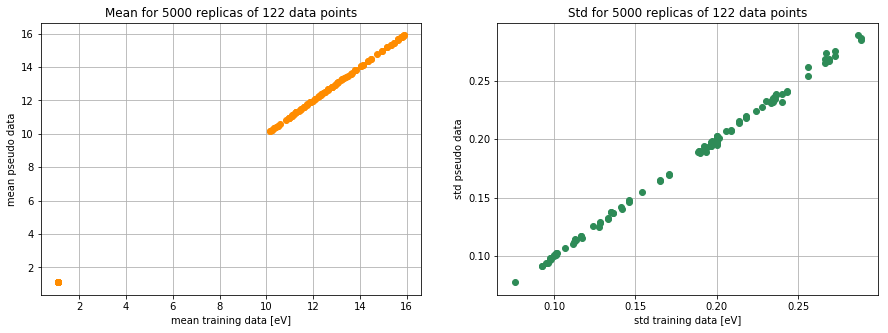

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
#plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
#plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [28]:
N_pred = 10000
predict_x = np.linspace(-.3,3,N_pred).reshape(N_pred,1)

In [30]:
import time
from datetime import datetime


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 1e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 30

    for i in range(Nrep):

        train_y = train_y_reps[:, i*25 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i*25 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 40000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 
                
                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            

            saver.restore(sess, best_model)

            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        now = datetime.now()

        dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
        d_string = now.strftime("%d.%m.%Y")
        t_string = now.strftime("%H:%M:%S")

        #foot = np.array(seednumber)
        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/%(date)s/x4_xyp1p2_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/%(date)s/x4_chi_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/%(date)s/x4_extrapolation_e%(epoch)s_round1_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Parallel training

In [31]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=6
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4,5,6])

pool.close()

#print(pool)


processor3 starts training on 0122 and validating on 0031 samples
processor2 starts training on 0122 and validating on 0031 samples
processor1 starts training on 0122 and validating on 0031 samples
processor6 starts training on 0122 and validating on 0031 samples
processor4 starts training on 0122 and validating on 0031 samples
processor5 starts training on 0122 and validating on 0031 samples
Epoch: 0001 | Training cost= 5607.887695312 | Validation cost= 6566.965820312
Epoch: 0001 | Training cost= 5591.341308594 | Validation cost= 6633.254882812
Epoch: 0001 | Training cost= 5587.248535156 | Validation cost= 6654.874023438
Epoch: 0001 | Training cost= 5600.909179688 | Validation cost= 6588.989746094
Epoch: 0001 | Training cost= 5599.568847656 | Validation cost= 6597.584960938
Epoch: 0001 | Training cost= 5611.670410156 | Validation cost= 6612.971679688
Epoch: 1001 | Training cost= 429.472961426 | Validation cost= 468.493347168
Epoch: 1001 | Training cost= 425.929168701 | Validation cost

Epoch: 17001 | Training cost= 1.129739761 | Validation cost= 1.248759866
Epoch: 18001 | Training cost= 1.026553988 | Validation cost= 1.961634755
Epoch: 18001 | Training cost= 1.358575463 | Validation cost= 1.489301801
Epoch: 18001 | Training cost= 0.927916944 | Validation cost= 1.027092218
Epoch: 18001 | Training cost= 1.127721667 | Validation cost= 1.325034022
Epoch: 18001 | Training cost= 1.315864563 | Validation cost= 1.379240751
Epoch: 18001 | Training cost= 1.128099442 | Validation cost= 1.253975153
Epoch: 19001 | Training cost= 1.024462938 | Validation cost= 1.960826039
Epoch: 19001 | Training cost= 1.357517719 | Validation cost= 1.484147310
Epoch: 19001 | Training cost= 1.313592434 | Validation cost= 1.375794888
Epoch: 19001 | Training cost= 1.124453068 | Validation cost= 1.314167261
Epoch: 19001 | Training cost= 0.925648034 | Validation cost= 1.025109172
Epoch: 19001 | Training cost= 1.126030922 | Validation cost= 1.234840035
Epoch: 20001 | Training cost= 1.022861004 | Validat

Epoch: 36001 | Training cost= 1.100088596 | Validation cost= 1.188395500
Epoch: 36001 | Training cost= 1.299704671 | Validation cost= 1.370326638
Epoch: 37001 | Training cost= 0.990891755 | Validation cost= 1.964307189
Epoch: 37001 | Training cost= 0.900084317 | Validation cost= 1.003593326
Epoch: 37001 | Training cost= 1.344174385 | Validation cost= 1.443379641
Epoch: 37001 | Training cost= 1.064595103 | Validation cost= 1.143990040
Epoch: 37001 | Training cost= 1.298650146 | Validation cost= 1.370945930
Epoch: 37001 | Training cost= 1.098313332 | Validation cost= 1.180120707
Epoch: 38001 | Training cost= 0.988900185 | Validation cost= 1.963308811
Epoch: 38001 | Training cost= 0.899237037 | Validation cost= 1.003605127
Epoch: 38001 | Training cost= 1.343483329 | Validation cost= 1.437652588
Epoch: 38001 | Training cost= 1.061589599 | Validation cost= 1.134636402
Epoch: 38001 | Training cost= 1.096848369 | Validation cost= 1.171658039
Epoch: 38001 | Training cost= 1.297575355 | Validat

Epoch: 8001 | Training cost= 1.268756747 | Validation cost= 1.566442370
Epoch: 9001 | Training cost= 1.266861558 | Validation cost= 2.308888674
Epoch: 9001 | Training cost= 1.267951250 | Validation cost= 2.276898861
Epoch: 9001 | Training cost= 1.530559421 | Validation cost= 2.788530111
Epoch: 9001 | Training cost= 1.345162511 | Validation cost= 1.983605862
Epoch: 9001 | Training cost= 1.409356356 | Validation cost= 1.494177699
Epoch: 9001 | Training cost= 1.203153014 | Validation cost= 1.460792184
Epoch: 10001 | Training cost= 1.233236432 | Validation cost= 2.316268682
Epoch: 10001 | Training cost= 1.226584196 | Validation cost= 2.324790239
Epoch: 10001 | Training cost= 1.319466472 | Validation cost= 2.049679041
Epoch: 10001 | Training cost= 1.505965352 | Validation cost= 2.871147871
Epoch: 10001 | Training cost= 1.361642838 | Validation cost= 1.539912343
Epoch: 10001 | Training cost= 1.181628704 | Validation cost= 1.415351629
Epoch: 11001 | Training cost= 1.214410782 | Validation cos

Epoch: 27001 | Training cost= 1.042440653 | Validation cost= 1.281107426
Epoch: 27001 | Training cost= 1.403534174 | Validation cost= 2.632443905
Epoch: 28001 | Training cost= 1.038136482 | Validation cost= 1.816051364
Epoch: 28001 | Training cost= 1.127240300 | Validation cost= 2.133180618
Epoch: 28001 | Training cost= 1.247719169 | Validation cost= 1.672190309
Epoch: 28001 | Training cost= 1.036919355 | Validation cost= 1.282222390
Epoch: 28001 | Training cost= 1.209952950 | Validation cost= 1.941282034
Epoch: 28001 | Training cost= 1.399950027 | Validation cost= 2.623877764
Epoch: 29001 | Training cost= 1.030792117 | Validation cost= 1.799391866
Epoch: 29001 | Training cost= 1.121893167 | Validation cost= 2.119698763
Epoch: 29001 | Training cost= 1.205281854 | Validation cost= 1.942014933
Epoch: 29001 | Training cost= 1.241891623 | Validation cost= 1.673725486
Epoch: 29001 | Training cost= 1.031344056 | Validation cost= 1.282351971
Epoch: 29001 | Training cost= 1.396245241 | Validat

Epoch: 4001 | Training cost= 4.283641338 | Validation cost= 3.040197134
Epoch: 4001 | Training cost= 4.293007851 | Validation cost= 2.423841953
Epoch: 4001 | Training cost= 4.072645187 | Validation cost= 1.795067072
Epoch: 5001 | Training cost= 2.298466921 | Validation cost= 2.829709053
Epoch: 5001 | Training cost= 1.982238054 | Validation cost= 1.629912615
Epoch: 5001 | Training cost= 2.161401033 | Validation cost= 1.818009615
Epoch: 5001 | Training cost= 2.091047049 | Validation cost= 1.166813970
Epoch: 5001 | Training cost= 2.349784136 | Validation cost= 1.730046391
Epoch: 5001 | Training cost= 2.224277735 | Validation cost= 1.072999120
Epoch: 6001 | Training cost= 1.810943961 | Validation cost= 2.860386133
Epoch: 6001 | Training cost= 1.666481853 | Validation cost= 1.423423052
Epoch: 6001 | Training cost= 1.798147440 | Validation cost= 1.806873441
Epoch: 6001 | Training cost= 1.577647805 | Validation cost= 1.530083776
Epoch: 6001 | Training cost= 1.882384181 | Validation cost= 1.75

Epoch: 23001 | Training cost= 1.049504042 | Validation cost= 1.893046260
Epoch: 23001 | Training cost= 1.052045941 | Validation cost= 1.487348795
Epoch: 23001 | Training cost= 1.352209091 | Validation cost= 1.584536672
Epoch: 24001 | Training cost= 1.160135746 | Validation cost= 2.279111862
Epoch: 23001 | Training cost= 1.080139637 | Validation cost= 1.619276524
Epoch: 24001 | Training cost= 1.060764909 | Validation cost= 1.139448881
Epoch: 24001 | Training cost= 1.039875388 | Validation cost= 1.457682729
Epoch: 24001 | Training cost= 1.039931536 | Validation cost= 1.870682120
Epoch: 24001 | Training cost= 1.339060664 | Validation cost= 1.572230816
Epoch: 24001 | Training cost= 1.076350927 | Validation cost= 1.608672142
Epoch: 25001 | Training cost= 1.126399040 | Validation cost= 2.213019848
Epoch: 25001 | Training cost= 1.052077413 | Validation cost= 1.121876359
Epoch: 25001 | Training cost= 1.027707577 | Validation cost= 1.420149565
Epoch: 25001 | Training cost= 1.033514977 | Validat

Epoch: 0001 | Training cost= 5199.768554688 | Validation cost= 6079.290039062
Epoch: 0001 | Training cost= 5197.451660156 | Validation cost= 6135.114257812
Epoch: 0001 | Training cost= 5171.763671875 | Validation cost= 6049.365722656
Epoch: 0001 | Training cost= 5181.209960938 | Validation cost= 6058.155273438
Epoch: 1001 | Training cost= 152.467849731 | Validation cost= 134.143463135
Epoch: 1001 | Training cost= 152.048873901 | Validation cost= 136.624252319
Epoch: 1001 | Training cost= 149.395980835 | Validation cost= 132.660598755
Epoch: 1001 | Training cost= 149.567230225 | Validation cost= 135.005874634
Epoch: 1001 | Training cost= 147.638015747 | Validation cost= 135.858276367
Epoch: 1001 | Training cost= 149.842361450 | Validation cost= 133.768661499
Epoch: 2001 | Training cost= 43.593833923 | Validation cost= 27.206001282
Epoch: 2001 | Training cost= 44.212577820 | Validation cost= 26.042543411
Epoch: 2001 | Training cost= 42.810146332 | Validation cost= 23.616788864
Epoch: 200

Epoch: 19001 | Training cost= 1.110192418 | Validation cost= 1.006193876
Epoch: 19001 | Training cost= 1.300938010 | Validation cost= 1.073725581
Epoch: 19001 | Training cost= 0.929530501 | Validation cost= 0.902375102
Epoch: 19001 | Training cost= 1.407027364 | Validation cost= 0.879800797
Epoch: 19001 | Training cost= 1.184263706 | Validation cost= 1.940487981
Epoch: 20001 | Training cost= 0.910669565 | Validation cost= 1.266253829
Epoch: 20001 | Training cost= 1.264684796 | Validation cost= 1.033436418
Epoch: 20001 | Training cost= 1.096034765 | Validation cost= 0.996614993
Epoch: 20001 | Training cost= 0.889181197 | Validation cost= 0.845343888
Epoch: 20001 | Training cost= 1.370347261 | Validation cost= 0.858767807
Epoch: 20001 | Training cost= 1.149733424 | Validation cost= 1.864546895
Epoch: 21001 | Training cost= 0.876539946 | Validation cost= 1.245572925
Epoch: 21001 | Training cost= 1.233853936 | Validation cost= 1.002102971
Epoch: 21001 | Training cost= 1.088039517 | Validat

Epoch: 37001 | Training cost= 0.993384302 | Validation cost= 1.804931402
Epoch: 38001 | Training cost= 1.130959749 | Validation cost= 0.934640765
Epoch: 38001 | Training cost= 0.934473932 | Validation cost= 0.838037193
Epoch: 38001 | Training cost= 0.776752472 | Validation cost= 0.698163986
Epoch: 38001 | Training cost= 1.125277758 | Validation cost= 0.877412617
Epoch: 39001 | Training cost= 0.805846930 | Validation cost= 1.268727779
Epoch: 38001 | Training cost= 0.992104709 | Validation cost= 1.813850760
Epoch: 39001 | Training cost= 0.931492865 | Validation cost= 0.834779084
Epoch: 39001 | Training cost= 1.129983664 | Validation cost= 0.934720993
Epoch: 39001 | Training cost= 0.776378512 | Validation cost= 0.698684275
Epoch: 39001 | Training cost= 1.123968601 | Validation cost= 0.880971730
Optimization 3 Finished! Best model after epoch 25000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 39001 | Training cost= 0.990833223 | Validation cost= 1.

Epoch: 14001 | Training cost= 1.470790982 | Validation cost= 1.412724733
Epoch: 15001 | Training cost= 1.037521243 | Validation cost= 1.990917087
Epoch: 15001 | Training cost= 0.994533002 | Validation cost= 1.534166455
Epoch: 15001 | Training cost= 1.064382911 | Validation cost= 1.532447815
Epoch: 15001 | Training cost= 1.236404896 | Validation cost= 1.590294600
Epoch: 16001 | Training cost= 1.014124870 | Validation cost= 1.256558537
Epoch: 15001 | Training cost= 1.458614588 | Validation cost= 1.400462270
Epoch: 16001 | Training cost= 0.982849956 | Validation cost= 1.533573985
Epoch: 16001 | Training cost= 0.996162772 | Validation cost= 1.960786343
Epoch: 16001 | Training cost= 1.045225620 | Validation cost= 1.533964038
Epoch: 16001 | Training cost= 1.213605046 | Validation cost= 1.584901333
Epoch: 17001 | Training cost= 1.002932668 | Validation cost= 1.262676597
Epoch: 16001 | Training cost= 1.451079130 | Validation cost= 1.393510342
Epoch: 17001 | Training cost= 0.973141074 | Validat

Epoch: 34001 | Training cost= 0.929053783 | Validation cost= 1.195698857
Epoch: 33001 | Training cost= 1.169979453 | Validation cost= 1.419456124
Epoch: 34001 | Training cost= 0.892420709 | Validation cost= 1.965566397
Epoch: 34001 | Training cost= 0.868016481 | Validation cost= 1.580453396
Epoch: 34001 | Training cost= 0.952838123 | Validation cost= 1.457993269
Epoch: 34001 | Training cost= 1.117318153 | Validation cost= 1.308977008
Epoch: 35001 | Training cost= 0.925523579 | Validation cost= 1.188392520
Epoch: 35001 | Training cost= 0.895747185 | Validation cost= 1.967916965
Epoch: 34001 | Training cost= 1.151906848 | Validation cost= 1.422324061
Epoch: 35001 | Training cost= 0.950857580 | Validation cost= 1.452861667
Epoch: 35001 | Training cost= 0.865830183 | Validation cost= 1.583566427
Epoch: 35001 | Training cost= 1.112625003 | Validation cost= 1.292804241
Epoch: 36001 | Training cost= 0.923032045 | Validation cost= 1.184323668
Epoch: 35001 | Training cost= 1.131380439 | Validat

Epoch: 11001 | Training cost= 1.653132319 | Validation cost= 1.376713872
Epoch: 11001 | Training cost= 1.316173911 | Validation cost= 1.404608250
Epoch: 11001 | Training cost= 1.562282443 | Validation cost= 2.057332277
Epoch: 10001 | Training cost= 1.424104571 | Validation cost= 2.158791304
Epoch: 11001 | Training cost= 1.558685064 | Validation cost= 2.016314983
Epoch: 11001 | Training cost= 1.566687822 | Validation cost= 1.940411925
Epoch: 12001 | Training cost= 1.636683345 | Validation cost= 1.362053394
Epoch: 12001 | Training cost= 1.551343799 | Validation cost= 2.047318697
Epoch: 12001 | Training cost= 1.305805802 | Validation cost= 1.395093799
Epoch: 11001 | Training cost= 1.410360694 | Validation cost= 2.131254196
Epoch: 12001 | Training cost= 1.550536394 | Validation cost= 2.002307177
Epoch: 12001 | Training cost= 1.558246374 | Validation cost= 1.931248069
Epoch: 13001 | Training cost= 1.622286439 | Validation cost= 1.349792838
Epoch: 13001 | Training cost= 1.296651125 | Validat

Epoch: 30001 | Training cost= 1.425051212 | Validation cost= 1.176761508
Epoch: 29001 | Training cost= 1.466223121 | Validation cost= 1.819140315
Epoch: 30001 | Training cost= 1.193439603 | Validation cost= 1.297776818
Epoch: 30001 | Training cost= 1.469591618 | Validation cost= 1.934669018
Epoch: 29001 | Training cost= 1.312673569 | Validation cost= 1.992396712
Epoch: 30001 | Training cost= 1.421755552 | Validation cost= 1.854232073
Epoch: 31001 | Training cost= 1.417363882 | Validation cost= 1.168430209
Epoch: 30001 | Training cost= 1.462048650 | Validation cost= 1.814158082
Epoch: 31001 | Training cost= 1.188690066 | Validation cost= 1.292774558
Epoch: 31001 | Training cost= 1.466055632 | Validation cost= 1.931951404
Epoch: 30001 | Training cost= 1.308423162 | Validation cost= 1.986338496
Epoch: 31001 | Training cost= 1.414085865 | Validation cost= 1.842794538
Epoch: 32001 | Training cost= 1.408786416 | Validation cost= 1.160774469
Epoch: 31001 | Training cost= 1.457936168 | Validat

Epoch: 6001 | Training cost= 1649.088500977 | Validation cost= 1804.021728516
Epoch: 6001 | Training cost= 1660.056884766 | Validation cost= 1772.813720703
Epoch: 5001 | Training cost= 2108.055175781 | Validation cost= 2318.191894531
Epoch: 7001 | Training cost= 1278.767211914 | Validation cost= 1351.150146484
Epoch: 6001 | Training cost= 1651.462646484 | Validation cost= 1792.273315430
Epoch: 7001 | Training cost= 1286.057128906 | Validation cost= 1342.879760742
Epoch: 7001 | Training cost= 1286.929809570 | Validation cost= 1335.756347656
Epoch: 7001 | Training cost= 1277.162231445 | Validation cost= 1365.104370117
Epoch: 6001 | Training cost= 1654.579956055 | Validation cost= 1775.962402344
Epoch: 8001 | Training cost= 988.105163574 | Validation cost= 1021.540954590
Epoch: 7001 | Training cost= 1279.255737305 | Validation cost= 1355.238403320
Epoch: 8001 | Training cost= 995.529113770 | Validation cost= 1010.576293945
Epoch: 8001 | Training cost= 995.709899902 | Validation cost= 1005

Epoch: 24001 | Training cost= 613.750183105 | Validation cost= 652.058715820
Epoch: 24001 | Training cost= 611.819580078 | Validation cost= 651.671264648
Epoch: 25001 | Training cost= 605.917053223 | Validation cost= 671.337768555
Epoch: 23001 | Training cost= 614.507690430 | Validation cost= 660.025207520
Epoch: 24001 | Training cost= 606.920654297 | Validation cost= 672.803039551
Epoch: 24001 | Training cost= 607.879394531 | Validation cost= 670.717834473
Epoch: 25001 | Training cost= 613.750122070 | Validation cost= 652.058593750
Epoch: 25001 | Training cost= 611.819580078 | Validation cost= 651.671264648
Epoch: 26001 | Training cost= 605.917053223 | Validation cost= 671.337768555
Epoch: 24001 | Training cost= 614.507690430 | Validation cost= 660.025207520
Epoch: 25001 | Training cost= 606.920593262 | Validation cost= 672.803039551
Epoch: 25001 | Training cost= 607.879394531 | Validation cost= 670.717834473
Epoch: 26001 | Training cost= 613.750183105 | Validation cost= 652.058715820

Epoch: 0001 | Training cost= 6305.005859375 | Validation cost= 7426.513183594
Epoch: 0001 | Training cost= 6323.188964844 | Validation cost= 7464.285156250
Epoch: 1001 | Training cost= 591.081481934 | Validation cost= 647.737792969
Epoch: 0001 | Training cost= 6293.601562500 | Validation cost= 7435.926757812
Epoch: 1001 | Training cost= 590.399536133 | Validation cost= 628.008300781
Optimization 6 Finished! Best model after epoch 11000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-11000
Epoch: 0001 | Training cost= 6310.394531250 | Validation cost= 7425.105957031
Epoch: 1001 | Training cost= 598.556274414 | Validation cost= 634.134399414
Epoch: 1001 | Training cost= 601.119262695 | Validation cost= 651.851867676
Epoch: 2001 | Training cost= 56.448703766 | Validation cost= 33.501640320
Epoch: 2001 | Training cost= 52.620838165 | Validation cost= 28.754987717
Epoch: 1001 | Training cost= 595.857788086 | Validation cost= 639.101867676
Epoch: 2001 | Training cos

Epoch: 18001 | Training cost= 0.968847752 | Validation cost= 1.369825840
Epoch: 19001 | Training cost= 1.044404745 | Validation cost= 1.664617300
Epoch: 19001 | Training cost= 1.016766310 | Validation cost= 1.704614401
Epoch: 19001 | Training cost= 1.140344262 | Validation cost= 1.280625463
Epoch: 18001 | Training cost= 1.326417446 | Validation cost= 1.032737255
Epoch: 20001 | Training cost= 1.209697485 | Validation cost= 1.534808755
Epoch: 19001 | Training cost= 0.962765455 | Validation cost= 1.359346867
Epoch: 20001 | Training cost= 1.043550611 | Validation cost= 1.664317727
Epoch: 20001 | Training cost= 1.021260262 | Validation cost= 1.684764147
Epoch: 20001 | Training cost= 1.133258343 | Validation cost= 1.298465610
Epoch: 19001 | Training cost= 1.323536158 | Validation cost= 1.023606300
Epoch: 21001 | Training cost= 1.194606304 | Validation cost= 1.531579733
Epoch: 20001 | Training cost= 0.956883192 | Validation cost= 1.347971201
Epoch: 21001 | Training cost= 1.036836982 | Validat

Epoch: 37001 | Training cost= 0.907833159 | Validation cost= 1.324982643
Epoch: 36001 | Training cost= 1.294657230 | Validation cost= 0.929660201
Epoch: 38001 | Training cost= 1.016152859 | Validation cost= 1.656384349
Epoch: 38001 | Training cost= 0.928355634 | Validation cost= 1.431577921
Epoch: 38001 | Training cost= 1.078591824 | Validation cost= 1.276944757
Epoch: 39001 | Training cost= 1.019830704 | Validation cost= 1.264965892
Epoch: 38001 | Training cost= 0.909826815 | Validation cost= 1.313607097
Epoch: 37001 | Training cost= 1.292014241 | Validation cost= 0.921723425
Epoch: 39001 | Training cost= 1.015226364 | Validation cost= 1.661605597
Epoch: 39001 | Training cost= 1.075044155 | Validation cost= 1.295555234
Epoch: 39001 | Training cost= 0.928727806 | Validation cost= 1.411591053
Optimization 7 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-39000
Epoch: 39001 | Training cost= 0.908313274 | Validation cost= 1.

Epoch: 15001 | Training cost= 1.149290919 | Validation cost= 1.421275854
Epoch: 14001 | Training cost= 1.408263564 | Validation cost= 1.816493154
Epoch: 15001 | Training cost= 1.133040309 | Validation cost= 1.764995217
Epoch: 13001 | Training cost= 1.211344838 | Validation cost= 2.041093588
Epoch: 15001 | Training cost= 1.357592225 | Validation cost= 1.567097425
Epoch: 15001 | Training cost= 1.017290115 | Validation cost= 1.756830931
Epoch: 16001 | Training cost= 1.143643737 | Validation cost= 1.414304376
Epoch: 15001 | Training cost= 1.402026653 | Validation cost= 1.794503212
Epoch: 16001 | Training cost= 1.121954799 | Validation cost= 1.750687361
Epoch: 14001 | Training cost= 1.206259251 | Validation cost= 2.047336102
Epoch: 16001 | Training cost= 1.351728439 | Validation cost= 1.561522841
Epoch: 16001 | Training cost= 1.010406375 | Validation cost= 1.754674673
Epoch: 17001 | Training cost= 1.137853980 | Validation cost= 1.407079935
Epoch: 16001 | Training cost= 1.395938158 | Validat

Epoch: 33001 | Training cost= 0.957433283 | Validation cost= 1.708630562
Epoch: 34001 | Training cost= 1.082046032 | Validation cost= 1.299655199
Epoch: 33001 | Training cost= 1.325624943 | Validation cost= 1.680523157
Epoch: 34001 | Training cost= 1.058288336 | Validation cost= 1.547187924
Epoch: 32001 | Training cost= 1.160979033 | Validation cost= 2.021277905
Epoch: 34001 | Training cost= 1.265300155 | Validation cost= 1.386642814
Epoch: 34001 | Training cost= 0.955228388 | Validation cost= 1.705889821
Epoch: 35001 | Training cost= 1.079920173 | Validation cost= 1.295547366
Epoch: 34001 | Training cost= 1.322335482 | Validation cost= 1.673902631
Epoch: 35001 | Training cost= 1.046944618 | Validation cost= 1.540638208
Epoch: 33001 | Training cost= 1.159190536 | Validation cost= 2.017930031
Epoch: 35001 | Training cost= 1.257482648 | Validation cost= 1.376903057
Epoch: 35001 | Training cost= 0.953067183 | Validation cost= 1.703167081
Epoch: 36001 | Training cost= 1.077868462 | Validat

Epoch: 10001 | Training cost= 1.889820457 | Validation cost= 2.613188267
Epoch: 11001 | Training cost= 1.518400431 | Validation cost= 1.130156159
Epoch: 10001 | Training cost= 1.735898614 | Validation cost= 2.730540037
Epoch: 11001 | Training cost= 1.998737454 | Validation cost= 2.096245289
Epoch: 11001 | Training cost= 1.902373075 | Validation cost= 2.184090376
Epoch: 9001 | Training cost= 1.904324889 | Validation cost= 2.288607836
Epoch: 11001 | Training cost= 1.841747642 | Validation cost= 2.556865931
Epoch: 12001 | Training cost= 1.474079728 | Validation cost= 1.088756680
Epoch: 11001 | Training cost= 1.671403646 | Validation cost= 2.600505590
Epoch: 12001 | Training cost= 1.960377574 | Validation cost= 2.088333607
Epoch: 12001 | Training cost= 1.859622717 | Validation cost= 2.098666430
Epoch: 12001 | Training cost= 1.809341073 | Validation cost= 2.522674561
Epoch: 10001 | Training cost= 1.819365740 | Validation cost= 2.110417604
Epoch: 13001 | Training cost= 1.444277644 | Validati

Epoch: 30001 | Training cost= 1.275911927 | Validation cost= 1.030812263
Epoch: 29001 | Training cost= 1.614401817 | Validation cost= 2.299099922
Epoch: 29001 | Training cost= 1.565452576 | Validation cost= 1.814357758
Epoch: 29001 | Training cost= 1.276455760 | Validation cost= 2.502344131
Epoch: 30001 | Training cost= 1.562497497 | Validation cost= 2.244627953
Epoch: 30001 | Training cost= 1.620022893 | Validation cost= 2.322839499
Epoch: 28001 | Training cost= 1.495903730 | Validation cost= 1.928268909
Epoch: 31001 | Training cost= 1.255068660 | Validation cost= 1.026528716
Epoch: 30001 | Training cost= 1.555323005 | Validation cost= 1.806435585
Epoch: 30001 | Training cost= 1.258382320 | Validation cost= 2.513561964
Epoch: 31001 | Training cost= 1.562727332 | Validation cost= 2.252823591
Epoch: 31001 | Training cost= 1.599617124 | Validation cost= 2.279323101
Epoch: 29001 | Training cost= 1.485865116 | Validation cost= 1.929841280
Epoch: 32001 | Training cost= 1.254346728 | Validat

Epoch: 7001 | Training cost= 1.818253517 | Validation cost= 2.233194828
Epoch: 6001 | Training cost= 2.778788090 | Validation cost= 2.418781757
Epoch: 4001 | Training cost= 8.789979935 | Validation cost= 11.266748428
Epoch: 6001 | Training cost= 2.658798218 | Validation cost= 2.589398623
Epoch: 6001 | Training cost= 2.490300655 | Validation cost= 2.716226339
Epoch: 7001 | Training cost= 1.845686078 | Validation cost= 1.702159047
Epoch: 8001 | Training cost= 1.564651966 | Validation cost= 1.945863485
Epoch: 7001 | Training cost= 1.813995123 | Validation cost= 1.725924015
Epoch: 5001 | Training cost= 4.899099350 | Validation cost= 5.681423187
Epoch: 7001 | Training cost= 1.808897018 | Validation cost= 1.635354280
Epoch: 7001 | Training cost= 1.619897485 | Validation cost= 1.654201627
Epoch: 8001 | Training cost= 1.541856289 | Validation cost= 1.472680807
Epoch: 9001 | Training cost= 1.504551649 | Validation cost= 1.925063610
Epoch: 8001 | Training cost= 1.539777637 | Validation cost= 1.4

Epoch: 26001 | Training cost= 1.405331135 | Validation cost= 1.928549528
Epoch: 25001 | Training cost= 1.187959313 | Validation cost= 1.485923052
Epoch: 25001 | Training cost= 1.252758980 | Validation cost= 1.310400844
Epoch: 23001 | Training cost= 1.104063511 | Validation cost= 1.889800787
Epoch: 25001 | Training cost= 1.076222897 | Validation cost= 1.235573530
Epoch: 27001 | Training cost= 1.403281331 | Validation cost= 1.911225080
Epoch: 26001 | Training cost= 1.182913184 | Validation cost= 1.508789062
Epoch: 25001 | Training cost= 1.147251964 | Validation cost= 1.088489056
Epoch: 26001 | Training cost= 1.268658876 | Validation cost= 1.333212376
Epoch: 24001 | Training cost= 1.099346995 | Validation cost= 1.886293530
Epoch: 26001 | Training cost= 1.073218703 | Validation cost= 1.241164088
Epoch: 28001 | Training cost= 1.397419453 | Validation cost= 1.914407849
Epoch: 27001 | Training cost= 1.154345751 | Validation cost= 1.504896045
Epoch: 26001 | Training cost= 1.145289183 | Validat

Epoch: 3001 | Training cost= 15.839300156 | Validation cost= 13.841053009
Epoch: 2001 | Training cost= 50.226551056 | Validation cost= 29.086984634
Epoch: 1001 | Training cost= 293.315368652 | Validation cost= 308.266357422
Epoch: 2001 | Training cost= 50.298629761 | Validation cost= 29.361610413
Epoch: 0001 | Training cost= 5958.058105469 | Validation cost= 6987.485839844
Epoch: 2001 | Training cost= 48.429912567 | Validation cost= 27.070335388
Epoch: 3001 | Training cost= 16.313249588 | Validation cost= 12.534620285
Epoch: 4001 | Training cost= 3.402052164 | Validation cost= 2.505162239
Epoch: 2001 | Training cost= 50.181953430 | Validation cost= 25.781833649
Epoch: 3001 | Training cost= 15.679400444 | Validation cost= 15.112759590
Epoch: 1001 | Training cost= 298.549377441 | Validation cost= 314.955963135
Epoch: 3001 | Training cost= 14.847270012 | Validation cost= 13.943675041
Epoch: 4001 | Training cost= 3.807338476 | Validation cost= 2.434981346
Epoch: 5001 | Training cost= 1.853

Epoch: 20001 | Training cost= 1.185849547 | Validation cost= 2.291259766
Epoch: 21001 | Training cost= 1.594444275 | Validation cost= 1.390103221
Epoch: 22001 | Training cost= 1.337173700 | Validation cost= 0.926979244
Epoch: 21001 | Training cost= 1.455870509 | Validation cost= 1.452471495
Epoch: 20001 | Training cost= 1.084753156 | Validation cost= 2.015669107
Epoch: 19001 | Training cost= 0.970248103 | Validation cost= 1.648798823
Epoch: 21001 | Training cost= 1.177270055 | Validation cost= 2.267628193
Epoch: 22001 | Training cost= 1.589691758 | Validation cost= 1.369508624
Epoch: 23001 | Training cost= 1.329736710 | Validation cost= 0.904535949
Epoch: 22001 | Training cost= 1.453446507 | Validation cost= 1.440251708
Epoch: 21001 | Training cost= 1.077252507 | Validation cost= 1.990555167
Epoch: 20001 | Training cost= 0.962947130 | Validation cost= 1.636792064
Epoch: 22001 | Training cost= 1.172917247 | Validation cost= 2.249568701
Epoch: 23001 | Training cost= 1.581683636 | Validat

Epoch: 38001 | Training cost= 0.991738677 | Validation cost= 1.727844715
Epoch: 0001 | Training cost= 5024.848632812 | Validation cost= 5878.812011719
Epoch: 37001 | Training cost= 0.863475621 | Validation cost= 1.436465383
Epoch: 39001 | Training cost= 1.086450458 | Validation cost= 1.964433193
Optimization 11 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-39000
Optimization 11 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Epoch: 39001 | Training cost= 0.989145577 | Validation cost= 1.717548847
Epoch: 0001 | Training cost= 5041.000976562 | Validation cost= 5808.549316406
Epoch: 1001 | Training cost= 111.984329224 | Validation cost= 89.285339355
Epoch: 38001 | Training cost= 0.860349536 | Validation cost= 1.428463101
Optimization 11 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000

Epoch: 16001 | Training cost= 1.421508193 | Validation cost= 1.392037511
Epoch: 15001 | Training cost= 1.411704183 | Validation cost= 1.342218995
Epoch: 14001 | Training cost= 1.394249558 | Validation cost= 1.456176281
Epoch: 17001 | Training cost= 1.313908458 | Validation cost= 2.407565594
Epoch: 18001 | Training cost= 1.286732554 | Validation cost= 0.789964199
Epoch: 17001 | Training cost= 1.089697599 | Validation cost= 1.526628256
Epoch: 17001 | Training cost= 1.408166766 | Validation cost= 1.370970845
Epoch: 16001 | Training cost= 1.404211879 | Validation cost= 1.342858911
Epoch: 18001 | Training cost= 1.302939415 | Validation cost= 2.392568350
Epoch: 15001 | Training cost= 1.377105594 | Validation cost= 1.442280173
Epoch: 19001 | Training cost= 1.255161166 | Validation cost= 0.776355624
Epoch: 18001 | Training cost= 1.072850108 | Validation cost= 1.512823343
Epoch: 18001 | Training cost= 1.391702533 | Validation cost= 1.352941751
Epoch: 17001 | Training cost= 1.395209193 | Validat

Epoch: 35001 | Training cost= 0.883219779 | Validation cost= 1.286485434
Epoch: 35001 | Training cost= 1.185089827 | Validation cost= 1.162287593
Epoch: 34001 | Training cost= 1.273814082 | Validation cost= 1.251536727
Epoch: 36001 | Training cost= 1.144332767 | Validation cost= 2.230977297
Epoch: 37001 | Training cost= 1.020248890 | Validation cost= 0.748041153
Epoch: 33001 | Training cost= 1.149560452 | Validation cost= 1.315025330
Epoch: 36001 | Training cost= 0.880719244 | Validation cost= 1.279536724
Epoch: 36001 | Training cost= 1.172941327 | Validation cost= 1.153298855
Epoch: 35001 | Training cost= 1.270805478 | Validation cost= 1.240244389
Epoch: 37001 | Training cost= 1.140508413 | Validation cost= 2.223775387
Epoch: 38001 | Training cost= 1.024626732 | Validation cost= 0.751589596
Epoch: 34001 | Training cost= 1.142145395 | Validation cost= 1.315885186
Epoch: 37001 | Training cost= 0.875756681 | Validation cost= 1.274422765
Epoch: 37001 | Training cost= 1.164856315 | Validat

Epoch: 12001 | Training cost= 1.513708830 | Validation cost= 2.237878084
Epoch: 12001 | Training cost= 1.800195932 | Validation cost= 1.171045184
Epoch: 13001 | Training cost= 1.735521078 | Validation cost= 1.463588715
Epoch: 11001 | Training cost= 1.708338261 | Validation cost= 1.931581616
Epoch: 14001 | Training cost= 1.624157310 | Validation cost= 1.563596249
Epoch: 10001 | Training cost= 1.564067245 | Validation cost= 2.194755554
Epoch: 13001 | Training cost= 1.492806435 | Validation cost= 2.239225626
Epoch: 13001 | Training cost= 1.782055140 | Validation cost= 1.144555807
Epoch: 14001 | Training cost= 1.718921065 | Validation cost= 1.426240683
Epoch: 12001 | Training cost= 1.673758030 | Validation cost= 1.849155545
Epoch: 15001 | Training cost= 1.607591152 | Validation cost= 1.542304516
Epoch: 11001 | Training cost= 1.528724074 | Validation cost= 2.155328751
Epoch: 14001 | Training cost= 1.474384069 | Validation cost= 2.240301132
Epoch: 14001 | Training cost= 1.764771581 | Validat

Epoch: 31001 | Training cost= 1.317542434 | Validation cost= 2.294420242
Epoch: 28001 | Training cost= 1.128411412 | Validation cost= 1.434273005
Epoch: 31001 | Training cost= 1.462900043 | Validation cost= 0.912203729
Epoch: 32001 | Training cost= 1.416965365 | Validation cost= 0.977905393
Epoch: 33001 | Training cost= 1.292207003 | Validation cost= 1.264345288
Epoch: 30001 | Training cost= 1.259270310 | Validation cost= 1.269850254
Epoch: 29001 | Training cost= 1.108616710 | Validation cost= 1.403635979
Epoch: 32001 | Training cost= 1.314675927 | Validation cost= 2.285321712
Epoch: 32001 | Training cost= 1.446904540 | Validation cost= 0.915394664
Epoch: 33001 | Training cost= 1.401163578 | Validation cost= 0.964184284
Epoch: 34001 | Training cost= 1.276143789 | Validation cost= 1.260385752
Epoch: 31001 | Training cost= 1.248600125 | Validation cost= 1.269324780
Epoch: 33001 | Training cost= 1.311983824 | Validation cost= 2.276124477
Epoch: 30001 | Training cost= 1.089346170 | Validat

Epoch: 6001 | Training cost= 1.642004132 | Validation cost= 1.498760104
Epoch: 8001 | Training cost= 1.509249806 | Validation cost= 1.544333339
Epoch: 5001 | Training cost= 1.248951912 | Validation cost= 2.248754501
Epoch: 8001 | Training cost= 1.330535650 | Validation cost= 1.722457767
Epoch: 10001 | Training cost= 1.600725532 | Validation cost= 1.167513609
Epoch: 7001 | Training cost= 1.557359338 | Validation cost= 1.324153900
Epoch: 9001 | Training cost= 1.200226545 | Validation cost= 1.678379416
Epoch: 9001 | Training cost= 1.468903542 | Validation cost= 1.476358175
Epoch: 6001 | Training cost= 1.187676907 | Validation cost= 1.997192740
Epoch: 9001 | Training cost= 1.287913680 | Validation cost= 1.696855903
Epoch: 11001 | Training cost= 1.575182915 | Validation cost= 1.152153134
Epoch: 8001 | Training cost= 1.515806675 | Validation cost= 1.268191218
Epoch: 10001 | Training cost= 1.179343224 | Validation cost= 1.661501765
Epoch: 10001 | Training cost= 1.440747261 | Validation cost= 

Epoch: 27001 | Training cost= 1.070214152 | Validation cost= 1.716562033
Epoch: 28001 | Training cost= 1.464848518 | Validation cost= 1.186128736
Epoch: 27001 | Training cost= 1.282909989 | Validation cost= 1.285837054
Epoch: 24001 | Training cost= 0.950548828 | Validation cost= 1.977903605
Epoch: 27001 | Training cost= 1.039430737 | Validation cost= 1.698698521
Epoch: 26001 | Training cost= 1.311670303 | Validation cost= 1.195200801
Epoch: 28001 | Training cost= 1.068277001 | Validation cost= 1.706528902
Epoch: 29001 | Training cost= 1.462655902 | Validation cost= 1.186691523
Epoch: 28001 | Training cost= 1.276848316 | Validation cost= 1.276909590
Epoch: 25001 | Training cost= 0.946353495 | Validation cost= 1.982519507
Epoch: 28001 | Training cost= 1.038135648 | Validation cost= 1.698337317
Epoch: 27001 | Training cost= 1.305026531 | Validation cost= 1.179109454
Epoch: 29001 | Training cost= 1.068333745 | Validation cost= 1.668702364
Epoch: 30001 | Training cost= 1.459864378 | Validat

Epoch: 5001 | Training cost= 6.345997334 | Validation cost= 6.296559811
Epoch: 4001 | Training cost= 8.515491486 | Validation cost= 6.782808304
Epoch: 2001 | Training cost= 48.317489624 | Validation cost= 29.653615952
Epoch: 4001 | Training cost= 8.000843048 | Validation cost= 7.039553642
Epoch: 4001 | Training cost= 8.276889801 | Validation cost= 5.039535522
Epoch: 1001 | Training cost= 80.426658630 | Validation cost= 46.258621216
Epoch: 6001 | Training cost= 3.791853666 | Validation cost= 3.713020563
Epoch: 5001 | Training cost= 6.158597469 | Validation cost= 4.974824905
Epoch: 3001 | Training cost= 11.505282402 | Validation cost= 13.637290001
Epoch: 5001 | Training cost= 5.903202057 | Validation cost= 4.939089298
Epoch: 5001 | Training cost= 5.833346367 | Validation cost= 3.157531023
Epoch: 2001 | Training cost= 49.958255768 | Validation cost= 29.082330704
Epoch: 6001 | Training cost= 3.720669746 | Validation cost= 3.132839680
Epoch: 7001 | Training cost= 2.536050081 | Validation co

Epoch: 19001 | Training cost= 1.537541986 | Validation cost= 1.694571018
Epoch: 23001 | Training cost= 1.804321647 | Validation cost= 2.210159302
Epoch: 21001 | Training cost= 1.582809806 | Validation cost= 1.961101651
Epoch: 24001 | Training cost= 1.790588379 | Validation cost= 2.241537571
Epoch: 23001 | Training cost= 1.564760327 | Validation cost= 1.356293321
Epoch: 23001 | Training cost= 1.329474688 | Validation cost= 1.377465606
Epoch: 20001 | Training cost= 1.516712427 | Validation cost= 1.666825056
Epoch: 24001 | Training cost= 1.776224017 | Validation cost= 2.178797007
Epoch: 22001 | Training cost= 1.569045544 | Validation cost= 1.964703321
Epoch: 25001 | Training cost= 1.759752512 | Validation cost= 2.214144945
Epoch: 24001 | Training cost= 1.539014459 | Validation cost= 1.341393352
Epoch: 24001 | Training cost= 1.308576345 | Validation cost= 1.361368299
Epoch: 21001 | Training cost= 1.495851159 | Validation cost= 1.640483618
Epoch: 25001 | Training cost= 1.748142004 | Validat

Epoch: 0001 | Training cost= 5505.957031250 | Validation cost= 6493.083496094
Optimization 15 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Epoch: 39001 | Training cost= 1.181307793 | Validation cost= 1.762903452
Epoch: 0001 | Training cost= 5484.026367188 | Validation cost= 6499.964355469
Epoch: 2001 | Training cost= 30.917009354 | Validation cost= 15.538542747
Epoch: 1001 | Training cost= 145.496871948 | Validation cost= 130.718276978
Epoch: 38001 | Training cost= 1.187340975 | Validation cost= 1.325380683
Epoch: 1001 | Training cost= 147.053985596 | Validation cost= 132.591995239
Optimization 15 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Epoch: 1001 | Training cost= 141.612487793 | Validation cost= 127.735900879
Epoch: 2001 | Training cost= 30.460100174 | Validation cost= 17.015460968
Epoch: 3001 | Training cost= 3.956879377 | Validatio

Epoch: 18001 | Training cost= 1.501089096 | Validation cost= 0.908370674
Epoch: 15001 | Training cost= 1.116740942 | Validation cost= 1.163232565
Epoch: 20001 | Training cost= 1.494837165 | Validation cost= 0.729147017
Epoch: 17001 | Training cost= 1.404989362 | Validation cost= 1.362794995
Epoch: 19001 | Training cost= 0.908087015 | Validation cost= 0.707018435
Epoch: 18001 | Training cost= 1.303691626 | Validation cost= 1.876507044
Epoch: 19001 | Training cost= 1.504367709 | Validation cost= 0.910431445
Epoch: 16001 | Training cost= 1.112015724 | Validation cost= 1.159000158
Epoch: 18001 | Training cost= 1.394646406 | Validation cost= 1.375521064
Epoch: 21001 | Training cost= 1.488832355 | Validation cost= 0.746621728
Epoch: 19001 | Training cost= 1.310101748 | Validation cost= 1.926013112
Epoch: 20001 | Training cost= 0.899254382 | Validation cost= 0.719058931
Epoch: 20001 | Training cost= 1.487868905 | Validation cost= 0.918551683
Epoch: 17001 | Training cost= 1.102597117 | Validat

Epoch: 36001 | Training cost= 1.262545347 | Validation cost= 1.942326427
Epoch: 37001 | Training cost= 1.448586583 | Validation cost= 0.895815611
Epoch: 38001 | Training cost= 0.864680946 | Validation cost= 0.779240131
Epoch: 39001 | Training cost= 1.359934211 | Validation cost= 0.756933630
Epoch: 34001 | Training cost= 1.039099216 | Validation cost= 1.116881371
Epoch: 36001 | Training cost= 1.357289553 | Validation cost= 1.359634757
Epoch: 37001 | Training cost= 1.262107372 | Validation cost= 1.950409412
Epoch: 38001 | Training cost= 1.470220327 | Validation cost= 0.869304121
Optimization 16 Finished! Best model after epoch 8000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-8000
Epoch: 39001 | Training cost= 0.863973260 | Validation cost= 0.776656747
Epoch: 35001 | Training cost= 1.039833665 | Validation cost= 1.120035291
Epoch: 38001 | Training cost= 1.261213422 | Validation cost= 1.955547810
Epoch: 37001 | Training cost= 1.355709434 | Validation cost= 1.3

Epoch: 13001 | Training cost= 607.926147461 | Validation cost= 657.039611816
Epoch: 12001 | Training cost= 609.734313965 | Validation cost= 672.278625488
Epoch: 14001 | Training cost= 607.244323730 | Validation cost= 667.713439941
Epoch: 15001 | Training cost= 612.110778809 | Validation cost= 669.127624512
Epoch: 10001 | Training cost= 659.268188477 | Validation cost= 671.163940430
Epoch: 13001 | Training cost= 615.234130859 | Validation cost= 668.051635742
Epoch: 14001 | Training cost= 607.926147461 | Validation cost= 657.039550781
Epoch: 13001 | Training cost= 609.734313965 | Validation cost= 672.278625488
Epoch: 15001 | Training cost= 607.244323730 | Validation cost= 667.713439941
Epoch: 16001 | Training cost= 612.110778809 | Validation cost= 669.127685547
Epoch: 11001 | Training cost= 612.901916504 | Validation cost= 661.382263184
Epoch: 14001 | Training cost= 615.234130859 | Validation cost= 668.051635742
Epoch: 15001 | Training cost= 607.926147461 | Validation cost= 657.039550781

Epoch: 30001 | Training cost= 615.234130859 | Validation cost= 668.051635742
Epoch: 31001 | Training cost= 607.926147461 | Validation cost= 657.039550781
Epoch: 30001 | Training cost= 609.734313965 | Validation cost= 672.278625488
Epoch: 33001 | Training cost= 612.110778809 | Validation cost= 669.127685547
Epoch: 32001 | Training cost= 607.244323730 | Validation cost= 667.713439941
Epoch: 28001 | Training cost= 612.579650879 | Validation cost= 665.458251953
Epoch: 31001 | Training cost= 615.234130859 | Validation cost= 668.051635742
Epoch: 32001 | Training cost= 607.926147461 | Validation cost= 657.039550781
Epoch: 31001 | Training cost= 609.734313965 | Validation cost= 672.278625488
Epoch: 34001 | Training cost= 612.110778809 | Validation cost= 669.127624512
Epoch: 33001 | Training cost= 607.244323730 | Validation cost= 667.713439941
Epoch: 29001 | Training cost= 612.579650879 | Validation cost= 665.458251953
Epoch: 32001 | Training cost= 615.234130859 | Validation cost= 668.051635742

Epoch: 9001 | Training cost= 2.181925774 | Validation cost= 2.019506931
Epoch: 8001 | Training cost= 2.520014524 | Validation cost= 2.848863125
Epoch: 6001 | Training cost= 2.785911798 | Validation cost= 3.544575691
Epoch: 4001 | Training cost= 3.166880846 | Validation cost= 2.789985657
Epoch: 7001 | Training cost= 2.450726986 | Validation cost= 2.487911701
Epoch: 8001 | Training cost= 2.430131912 | Validation cost= 2.881902933
Epoch: 10001 | Training cost= 1.933310986 | Validation cost= 1.790346026
Epoch: 9001 | Training cost= 2.329392672 | Validation cost= 2.625142813
Epoch: 7001 | Training cost= 2.595171213 | Validation cost= 3.285094500
Epoch: 5001 | Training cost= 2.954024315 | Validation cost= 2.723355770
Epoch: 8001 | Training cost= 2.234136581 | Validation cost= 2.319086790
Epoch: 9001 | Training cost= 2.273998737 | Validation cost= 2.692975521
Epoch: 11001 | Training cost= 1.747729778 | Validation cost= 1.552081585
Epoch: 10001 | Training cost= 2.118884325 | Validation cost= 2

Epoch: 26001 | Training cost= 1.406566143 | Validation cost= 1.666789055
Epoch: 28001 | Training cost= 1.288011789 | Validation cost= 1.432002902
Epoch: 27001 | Training cost= 1.360405445 | Validation cost= 1.483089566
Epoch: 25001 | Training cost= 1.516201138 | Validation cost= 1.662197590
Epoch: 26001 | Training cost= 1.123937368 | Validation cost= 1.357433200
Epoch: 23001 | Training cost= 1.348205686 | Validation cost= 1.027997136
Epoch: 27001 | Training cost= 1.398866773 | Validation cost= 1.668996930
Epoch: 29001 | Training cost= 1.281718731 | Validation cost= 1.433440685
Epoch: 28001 | Training cost= 1.347921133 | Validation cost= 1.483808160
Epoch: 26001 | Training cost= 1.511659861 | Validation cost= 1.662952185
Epoch: 27001 | Training cost= 1.125948906 | Validation cost= 1.354333282
Epoch: 24001 | Training cost= 1.341703057 | Validation cost= 1.026608109
Epoch: 28001 | Training cost= 1.391843915 | Validation cost= 1.669559479
Epoch: 30001 | Training cost= 1.275235176 | Validat

Epoch: 3001 | Training cost= 13.492061615 | Validation cost= 6.606147289
Optimization 18 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-39000
Epoch: 2001 | Training cost= 48.105400085 | Validation cost= 30.221759796
Epoch: 3001 | Training cost= 11.938266754 | Validation cost= 9.200246811
Epoch: 4001 | Training cost= 3.571961641 | Validation cost= 3.834304810
Epoch: 0001 | Training cost= 4855.633300781 | Validation cost= 5581.829589844
Epoch: 6001 | Training cost= 2.167922020 | Validation cost= 2.292691231
Epoch: 4001 | Training cost= 3.805164099 | Validation cost= 4.303621292
Epoch: 3001 | Training cost= 11.799714088 | Validation cost= 7.038302422
Epoch: 4001 | Training cost= 3.563588381 | Validation cost= 7.029981613
Epoch: 5001 | Training cost= 2.496500254 | Validation cost= 2.767278433
Epoch: 1001 | Training cost= 72.811302185 | Validation cost= 42.292705536
Epoch: 7001 | Training cost= 1.971273184 | Validation cost= 

Epoch: 22001 | Training cost= 1.418436885 | Validation cost= 1.638436675
Epoch: 24001 | Training cost= 1.614269376 | Validation cost= 1.350487828
Epoch: 18001 | Training cost= 1.671245217 | Validation cost= 2.376928568
Epoch: 22001 | Training cost= 1.488950133 | Validation cost= 1.819631815
Epoch: 21001 | Training cost= 1.607287526 | Validation cost= 1.254017591
Epoch: 22001 | Training cost= 1.596690178 | Validation cost= 2.696723938
Epoch: 23001 | Training cost= 1.398063421 | Validation cost= 1.618922710
Epoch: 25001 | Training cost= 1.600678444 | Validation cost= 1.326452494
Epoch: 19001 | Training cost= 1.659113288 | Validation cost= 2.340457678
Epoch: 23001 | Training cost= 1.478847623 | Validation cost= 1.790136814
Epoch: 22001 | Training cost= 1.593624234 | Validation cost= 1.232730985
Epoch: 24001 | Training cost= 1.390816331 | Validation cost= 1.609622359
Epoch: 23001 | Training cost= 1.589001179 | Validation cost= 2.680559874
Epoch: 26001 | Training cost= 1.591806054 | Validat

Epoch: 0001 | Training cost= 5206.086914062 | Validation cost= 6017.901367188
Epoch: 2001 | Training cost= 49.867469788 | Validation cost= 27.020357132
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Epoch: 39001 | Training cost= 1.423396707 | Validation cost= 1.190712929
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Epoch: 0001 | Training cost= 5186.406738281 | Validation cost= 6082.878417969
Epoch: 37001 | Training cost= 1.488512397 | Validation cost= 2.084721804
Epoch: 1001 | Training cost= 86.720565796 | Validation cost= 53.424755096
Epoch: 0001 | Training cost= 5170.125000000 | Validation cost= 6066.923339844
Epoch: 3001 | Training cost= 13.350960732 | Validation cost= 12.929598808
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt

Epoch: 18001 | Training cost= 1.518060327 | Validation cost= 1.372615933
Epoch: 16001 | Training cost= 1.234914303 | Validation cost= 1.958156943
Epoch: 17001 | Training cost= 1.619645834 | Validation cost= 1.801752567
Epoch: 20001 | Training cost= 1.135369182 | Validation cost= 1.010545373
Epoch: 14001 | Training cost= 1.137980580 | Validation cost= 2.101668596
Epoch: 18001 | Training cost= 1.785790563 | Validation cost= 1.237892866
Epoch: 19001 | Training cost= 1.480729699 | Validation cost= 1.351047039
Epoch: 17001 | Training cost= 1.190185428 | Validation cost= 1.952903628
Epoch: 18001 | Training cost= 1.564116716 | Validation cost= 1.760324836
Epoch: 21001 | Training cost= 1.110231757 | Validation cost= 0.985100150
Epoch: 15001 | Training cost= 1.118479013 | Validation cost= 2.097410679
Epoch: 19001 | Training cost= 1.703228354 | Validation cost= 1.197527647
Epoch: 20001 | Training cost= 1.442277551 | Validation cost= 1.329370975
Epoch: 18001 | Training cost= 1.142670870 | Validat

Epoch: 37001 | Training cost= 1.177728772 | Validation cost= 1.291409969
Epoch: 36001 | Training cost= 1.330495477 | Validation cost= 1.328112483
Epoch: 35001 | Training cost= 0.927695811 | Validation cost= 1.570075035
Epoch: 36001 | Training cost= 1.145198941 | Validation cost= 1.323231101
Epoch: 39001 | Training cost= 0.965470493 | Validation cost= 0.975423157
Epoch: 33001 | Training cost= 0.891282916 | Validation cost= 1.650813937
Epoch: 38001 | Training cost= 1.173282504 | Validation cost= 1.292653680
Epoch: 37001 | Training cost= 1.324895620 | Validation cost= 1.340230465
Epoch: 36001 | Training cost= 0.924504876 | Validation cost= 1.558422327
Epoch: 37001 | Training cost= 1.139577985 | Validation cost= 1.319226980
Optimization 20 Finished! Best model after epoch 26000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 34001 | Training cost= 0.891583502 | Validation cost= 1.642916441
Epoch: 0001 | Training cost= 5673.880859375 | Validation cost=

Epoch: 12001 | Training cost= 621.431762695 | Validation cost= 649.213623047
Epoch: 11001 | Training cost= 614.562561035 | Validation cost= 651.606506348
Epoch: 15001 | Training cost= 603.810302734 | Validation cost= 656.609497070
Epoch: 12001 | Training cost= 613.990783691 | Validation cost= 665.415832520
Epoch: 9001 | Training cost= 786.940368652 | Validation cost= 785.806213379
Epoch: 14001 | Training cost= 606.116271973 | Validation cost= 667.295593262
Epoch: 13001 | Training cost= 621.431762695 | Validation cost= 649.213684082
Epoch: 12001 | Training cost= 614.235900879 | Validation cost= 655.079895020
Epoch: 16001 | Training cost= 603.810302734 | Validation cost= 656.609558105
Epoch: 13001 | Training cost= 613.990783691 | Validation cost= 665.415710449
Epoch: 10001 | Training cost= 659.904052734 | Validation cost= 667.072326660
Epoch: 15001 | Training cost= 606.116271973 | Validation cost= 667.295593262
Epoch: 14001 | Training cost= 621.431762695 | Validation cost= 649.213684082


Epoch: 30001 | Training cost= 621.431762695 | Validation cost= 649.213684082
Epoch: 31001 | Training cost= 606.116271973 | Validation cost= 667.295593262
Epoch: 33001 | Training cost= 603.810302734 | Validation cost= 656.609497070
Epoch: 30001 | Training cost= 613.990783691 | Validation cost= 665.415832520
Epoch: 29001 | Training cost= 614.235961914 | Validation cost= 655.079772949
Epoch: 31001 | Training cost= 621.431762695 | Validation cost= 649.213684082
Epoch: 27001 | Training cost= 613.801757812 | Validation cost= 656.393859863
Epoch: 32001 | Training cost= 606.116271973 | Validation cost= 667.295593262
Epoch: 34001 | Training cost= 603.810302734 | Validation cost= 656.609558105
Epoch: 30001 | Training cost= 614.235900879 | Validation cost= 655.079895020
Epoch: 31001 | Training cost= 613.990783691 | Validation cost= 665.415832520
Epoch: 32001 | Training cost= 621.431762695 | Validation cost= 649.213623047
Epoch: 28001 | Training cost= 613.801757812 | Validation cost= 656.393859863

Epoch: 6001 | Training cost= 1.931876779 | Validation cost= 2.138203144
Epoch: 5001 | Training cost= 1.643960476 | Validation cost= 1.948905706
Epoch: 6001 | Training cost= 1.284271955 | Validation cost= 1.780752420
Epoch: 8001 | Training cost= 1.100487828 | Validation cost= 1.473553777
Epoch: 10001 | Training cost= 1.317726851 | Validation cost= 1.629850864
Epoch: 3001 | Training cost= 4.207489491 | Validation cost= 4.624530315
Epoch: 7001 | Training cost= 1.858461142 | Validation cost= 2.006700039
Epoch: 6001 | Training cost= 1.583162427 | Validation cost= 1.943200111
Epoch: 7001 | Training cost= 1.252839208 | Validation cost= 1.725402117
Epoch: 9001 | Training cost= 1.093627572 | Validation cost= 1.440622211
Epoch: 4001 | Training cost= 1.977689743 | Validation cost= 1.789055347
Epoch: 11001 | Training cost= 1.311758995 | Validation cost= 1.617924333
Epoch: 8001 | Training cost= 1.809280038 | Validation cost= 1.905104160
Epoch: 7001 | Training cost= 1.568516135 | Validation cost= 1.

Epoch: 24001 | Training cost= 1.474517226 | Validation cost= 1.671663404
Epoch: 21001 | Training cost= 1.343569875 | Validation cost= 1.055523515
Epoch: 25001 | Training cost= 1.490267277 | Validation cost= 1.540261984
Epoch: 25001 | Training cost= 1.114595056 | Validation cost= 1.326642036
Epoch: 29001 | Training cost= 1.291600943 | Validation cost= 1.570050836
Epoch: 25001 | Training cost= 1.469334960 | Validation cost= 1.655470967
Epoch: 27001 | Training cost= 1.063648462 | Validation cost= 1.293688655
Epoch: 22001 | Training cost= 1.342671037 | Validation cost= 1.062040567
Epoch: 26001 | Training cost= 1.471290588 | Validation cost= 1.532440901
Epoch: 26001 | Training cost= 1.112632394 | Validation cost= 1.319426537
Epoch: 30001 | Training cost= 1.294610500 | Validation cost= 1.592646003
Epoch: 26001 | Training cost= 1.464778185 | Validation cost= 1.644577146
Epoch: 28001 | Training cost= 1.059764385 | Validation cost= 1.279028177
Epoch: 23001 | Training cost= 1.340229869 | Validat

Epoch: 3001 | Training cost= 3.708009958 | Validation cost= 5.469657421
Epoch: 2001 | Training cost= 40.681465149 | Validation cost= 24.920516968
Epoch: 2001 | Training cost= 40.708045959 | Validation cost= 24.418788910
Epoch: 39001 | Training cost= 1.301346183 | Validation cost= 1.030914426
Epoch: 6001 | Training cost= 1.493010402 | Validation cost= 2.120985270
Epoch: 2001 | Training cost= 39.394065857 | Validation cost= 23.674514771
Epoch: 4001 | Training cost= 1.681072593 | Validation cost= 2.994263172
Epoch: 3001 | Training cost= 3.767370462 | Validation cost= 4.562861919
Epoch: 3001 | Training cost= 3.846000910 | Validation cost= 6.275945187
Optimization 22 Finished! Best model after epoch 36000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-36000
Epoch: 7001 | Training cost= 1.469333053 | Validation cost= 2.066060066
Epoch: 3001 | Training cost= 4.257399082 | Validation cost= 4.874180794
Epoch: 5001 | Training cost= 1.039074540 | Validation cost= 2.0382

Epoch: 24001 | Training cost= 1.305423856 | Validation cost= 1.997160316
Epoch: 20001 | Training cost= 1.575083494 | Validation cost= 1.595033050
Epoch: 22001 | Training cost= 0.906557739 | Validation cost= 1.728795052
Epoch: 17001 | Training cost= 1.332173586 | Validation cost= 1.245416880
Epoch: 21001 | Training cost= 1.225522041 | Validation cost= 2.109466553
Epoch: 21001 | Training cost= 1.137047052 | Validation cost= 1.007973671
Epoch: 25001 | Training cost= 1.292113066 | Validation cost= 2.036808968
Epoch: 21001 | Training cost= 1.568954349 | Validation cost= 1.593855143
Epoch: 23001 | Training cost= 0.905552983 | Validation cost= 1.727984905
Epoch: 18001 | Training cost= 1.324694991 | Validation cost= 1.238800764
Epoch: 22001 | Training cost= 1.223394752 | Validation cost= 2.111176968
Epoch: 22001 | Training cost= 1.133037448 | Validation cost= 1.009606004
Epoch: 26001 | Training cost= 1.281782031 | Validation cost= 2.022528410
Epoch: 22001 | Training cost= 1.560924649 | Validat

INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-37000
Epoch: 35001 | Training cost= 1.237502098 | Validation cost= 1.075222373
Epoch: 39001 | Training cost= 1.206895709 | Validation cost= 2.004695654
Epoch: 39001 | Training cost= 1.076203465 | Validation cost= 0.940736055
Epoch: 39001 | Training cost= 1.408647776 | Validation cost= 1.561629057
Epoch: 0001 | Training cost= 6388.891601562 | Validation cost= 7639.038574219
Epoch: 3001 | Training cost= 3.376154184 | Validation cost= 4.906399250
Epoch: 36001 | Training cost= 1.234130740 | Validation cost= 1.069836378
Optimization 23 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Optimization 23 Finished! Best model after epoch 38000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-38000
Optimization 23 Finished! Best model after epoch 35000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-35000


Epoch: 12001 | Training cost= 1.372618675 | Validation cost= 1.770261407
Epoch: 16001 | Training cost= 1.267261267 | Validation cost= 1.947122097
Epoch: 16001 | Training cost= 1.219041824 | Validation cost= 1.532071471
Epoch: 16001 | Training cost= 1.358940840 | Validation cost= 0.926561058
Epoch: 18001 | Training cost= 1.377509236 | Validation cost= 1.406772137
Epoch: 21001 | Training cost= 1.222903848 | Validation cost= 2.113681078
Epoch: 13001 | Training cost= 1.351979494 | Validation cost= 1.769197822
Epoch: 17001 | Training cost= 1.264912128 | Validation cost= 1.949174285
Epoch: 17001 | Training cost= 1.214799881 | Validation cost= 1.604002714
Epoch: 17001 | Training cost= 1.353148937 | Validation cost= 0.930426419
Epoch: 19001 | Training cost= 1.371780753 | Validation cost= 1.401348472
Epoch: 22001 | Training cost= 1.216117024 | Validation cost= 2.121511936
Epoch: 14001 | Training cost= 1.334946036 | Validation cost= 1.777542114
Epoch: 18001 | Training cost= 1.262110114 | Validat

Epoch: 39001 | Training cost= 1.207438707 | Validation cost= 2.255713224
Epoch: 31001 | Training cost= 1.209814429 | Validation cost= 1.770963311
Epoch: 35001 | Training cost= 1.049413919 | Validation cost= 1.659975410
Epoch: 35001 | Training cost= 1.233144522 | Validation cost= 1.848073006
Epoch: 35001 | Training cost= 1.263159275 | Validation cost= 0.845665455
Epoch: 37001 | Training cost= 1.282102346 | Validation cost= 1.284582615
Optimization 24 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-9000
Epoch: 32001 | Training cost= 1.208061934 | Validation cost= 1.769762158
Epoch: 36001 | Training cost= 1.041582108 | Validation cost= 1.664180875
Epoch: 36001 | Training cost= 1.231703997 | Validation cost= 1.842240334
Epoch: 0001 | Training cost= 5459.205566406 | Validation cost= 6406.681152344
Epoch: 36001 | Training cost= 1.257991672 | Validation cost= 0.839131534
Epoch: 38001 | Training cost= 1.277804613 | Validation cost

Epoch: 13001 | Training cost= 1.339451313 | Validation cost= 1.907641530
Epoch: 16001 | Training cost= 0.992058754 | Validation cost= 1.311598539
Epoch: 12001 | Training cost= 1.236731648 | Validation cost= 2.050142527
Epoch: 8001 | Training cost= 1.394735098 | Validation cost= 1.152257681
Epoch: 12001 | Training cost= 1.326482415 | Validation cost= 1.604713917
Epoch: 14001 | Training cost= 1.286130786 | Validation cost= 1.870591879
Epoch: 12001 | Training cost= 1.285017133 | Validation cost= 1.649671316
Epoch: 17001 | Training cost= 0.982071102 | Validation cost= 1.303553939
Epoch: 13001 | Training cost= 1.201051235 | Validation cost= 2.020412683
Epoch: 9001 | Training cost= 1.370092750 | Validation cost= 1.164701700
Epoch: 13001 | Training cost= 1.277734876 | Validation cost= 1.570608974
Epoch: 13001 | Training cost= 1.254194975 | Validation cost= 1.631343246
Epoch: 15001 | Training cost= 1.244352818 | Validation cost= 1.879310608
Epoch: 18001 | Training cost= 0.960933208 | Validatio

Epoch: 30001 | Training cost= 0.999109089 | Validation cost= 1.298887014
Epoch: 32001 | Training cost= 1.046566606 | Validation cost= 1.413615704
Epoch: 35001 | Training cost= 0.886262357 | Validation cost= 1.157923818
Epoch: 31001 | Training cost= 1.002998352 | Validation cost= 1.703917503
Epoch: 27001 | Training cost= 1.191791415 | Validation cost= 1.050097227
Epoch: 31001 | Training cost= 1.096373916 | Validation cost= 1.324420214
Epoch: 31001 | Training cost= 0.994609892 | Validation cost= 1.301139474
Epoch: 36001 | Training cost= 0.863277137 | Validation cost= 1.123731732
Epoch: 33001 | Training cost= 1.038039804 | Validation cost= 1.379275084
Epoch: 28001 | Training cost= 1.189040303 | Validation cost= 1.039334655
Epoch: 32001 | Training cost= 1.001616359 | Validation cost= 1.697128773
Epoch: 32001 | Training cost= 1.092458725 | Validation cost= 1.304360390
Epoch: 32001 | Training cost= 0.987255394 | Validation cost= 1.297872782
Epoch: 37001 | Training cost= 0.860125542 | Validat

Epoch: 7001 | Training cost= 1288.478515625 | Validation cost= 1359.290771484
Epoch: 3001 | Training cost= 3274.974121094 | Validation cost= 3760.929687500
Epoch: 7001 | Training cost= 1278.401489258 | Validation cost= 1347.633300781
Epoch: 7001 | Training cost= 1273.883178711 | Validation cost= 1355.988281250
Epoch: 12001 | Training cost= 610.461730957 | Validation cost= 661.332946777
Epoch: 9001 | Training cost= 784.358764648 | Validation cost= 789.491638184
Epoch: 8001 | Training cost= 997.882873535 | Validation cost= 1022.517456055
Epoch: 8001 | Training cost= 989.732482910 | Validation cost= 1018.026672363
Epoch: 4001 | Training cost= 2656.365966797 | Validation cost= 3001.542236328
Epoch: 8001 | Training cost= 985.576721191 | Validation cost= 1024.023315430
Epoch: 13001 | Training cost= 610.461669922 | Validation cost= 661.333129883
Epoch: 10001 | Training cost= 656.829162598 | Validation cost= 666.355407715
Epoch: 9001 | Training cost= 789.122863770 | Validation cost= 791.939697

Epoch: 26001 | Training cost= 610.203735352 | Validation cost= 651.289978027
Epoch: 25001 | Training cost= 615.897216797 | Validation cost= 650.412170410
Epoch: 25001 | Training cost= 613.604309082 | Validation cost= 666.688110352
Epoch: 25001 | Training cost= 610.546264648 | Validation cost= 665.340698242
Epoch: 21001 | Training cost= 618.658081055 | Validation cost= 664.394042969
Epoch: 30001 | Training cost= 610.461730957 | Validation cost= 661.333129883
Epoch: 27001 | Training cost= 610.203735352 | Validation cost= 651.289916992
Epoch: 26001 | Training cost= 615.897216797 | Validation cost= 650.412170410
Epoch: 26001 | Training cost= 613.604370117 | Validation cost= 666.688110352
Epoch: 26001 | Training cost= 610.546264648 | Validation cost= 665.340698242
Epoch: 22001 | Training cost= 618.658081055 | Validation cost= 664.394165039
Epoch: 31001 | Training cost= 610.461730957 | Validation cost= 661.332946777
Epoch: 28001 | Training cost= 610.203735352 | Validation cost= 651.289978027

Epoch: 1001 | Training cost= 153.010177612 | Validation cost= 132.277557373
Epoch: 1001 | Training cost= 149.036819458 | Validation cost= 136.599685669
Epoch: 1001 | Training cost= 147.965057373 | Validation cost= 133.338439941
Epoch: 6001 | Training cost= 1.408378720 | Validation cost= 1.916678905
Epoch: 3001 | Training cost= 3.899692059 | Validation cost= 6.054905891
Epoch: 2001 | Training cost= 42.682102203 | Validation cost= 26.132247925
Epoch: 38001 | Training cost= 618.658081055 | Validation cost= 664.394165039
Epoch: 2001 | Training cost= 42.026912689 | Validation cost= 29.255495071
Epoch: 2001 | Training cost= 40.750019073 | Validation cost= 28.181636810
Epoch: 7001 | Training cost= 1.319566965 | Validation cost= 1.728093266
Epoch: 4001 | Training cost= 1.956544638 | Validation cost= 3.482199430
Epoch: 39001 | Training cost= 618.658020020 | Validation cost= 664.394042969
Epoch: 3001 | Training cost= 4.466021061 | Validation cost= 4.318216801
Epoch: 3001 | Training cost= 3.78921

Epoch: 15001 | Training cost= 1.265410900 | Validation cost= 1.543536663
Epoch: 21001 | Training cost= 1.283152580 | Validation cost= 1.843134403
Epoch: 20001 | Training cost= 0.898583531 | Validation cost= 1.388457298
Epoch: 20001 | Training cost= 1.464279175 | Validation cost= 1.345970750
Epoch: 20001 | Training cost= 1.140922666 | Validation cost= 1.283151984
Epoch: 25001 | Training cost= 1.144984126 | Validation cost= 1.578831434
Epoch: 16001 | Training cost= 1.260915518 | Validation cost= 1.544116020
Epoch: 22001 | Training cost= 1.277176619 | Validation cost= 1.840825319
Epoch: 21001 | Training cost= 0.893655181 | Validation cost= 1.395169020
Epoch: 21001 | Training cost= 1.460111022 | Validation cost= 1.346166849
Epoch: 21001 | Training cost= 1.137697220 | Validation cost= 1.290541410
Epoch: 26001 | Training cost= 1.143550038 | Validation cost= 1.561290503
Epoch: 17001 | Training cost= 1.257391930 | Validation cost= 1.545681357
Epoch: 23001 | Training cost= 1.272927999 | Validat

Epoch: 38001 | Training cost= 1.419996023 | Validation cost= 1.283467174
Epoch: 38001 | Training cost= 1.101633549 | Validation cost= 1.262441754
Optimization 27 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-39000
Epoch: 34001 | Training cost= 1.222337008 | Validation cost= 1.540665388
Epoch: 3001 | Training cost= 8.514900208 | Validation cost= 8.216792107
Epoch: 39001 | Training cost= 0.851385951 | Validation cost= 1.484503984
Epoch: 39001 | Training cost= 1.420628548 | Validation cost= 1.280202270
Epoch: 0001 | Training cost= 5358.126953125 | Validation cost= 6271.812500000
Epoch: 39001 | Training cost= 1.105804801 | Validation cost= 1.274138927
Epoch: 35001 | Training cost= 1.221098304 | Validation cost= 1.541648626
Epoch: 4001 | Training cost= 4.491028786 | Validation cost= 4.615326881
Optimization 27 Finished! Best model after epoch 15000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-150

Epoch: 15001 | Training cost= 1.143004537 | Validation cost= 1.592567205
Epoch: 20001 | Training cost= 1.558738112 | Validation cost= 1.411186695
Epoch: 17001 | Training cost= 1.461738229 | Validation cost= 1.651579857
Epoch: 11001 | Training cost= 1.440950632 | Validation cost= 1.863265276
Epoch: 16001 | Training cost= 1.435125828 | Validation cost= 1.670668125
Epoch: 16001 | Training cost= 1.433747172 | Validation cost= 1.964592934
Epoch: 16001 | Training cost= 1.121103168 | Validation cost= 1.530868053
Epoch: 21001 | Training cost= 1.545091510 | Validation cost= 1.406520963
Epoch: 18001 | Training cost= 1.432292461 | Validation cost= 1.569238186
Epoch: 12001 | Training cost= 1.414728761 | Validation cost= 1.848950505
Epoch: 17001 | Training cost= 1.409277439 | Validation cost= 1.654189825
Epoch: 17001 | Training cost= 1.424799323 | Validation cost= 1.957256556
Epoch: 17001 | Training cost= 1.073133707 | Validation cost= 1.537753105
Epoch: 22001 | Training cost= 1.531335115 | Validat

Epoch: 34001 | Training cost= 1.153306842 | Validation cost= 1.795953512
Epoch: 34001 | Training cost= 0.778863668 | Validation cost= 1.310994625
Epoch: 39001 | Training cost= 1.164515734 | Validation cost= 1.226162195
Epoch: 36001 | Training cost= 1.133901715 | Validation cost= 1.290665150
Epoch: 30001 | Training cost= 1.018075228 | Validation cost= 1.216341734
Epoch: 35001 | Training cost= 1.044173598 | Validation cost= 1.322786689
Epoch: 35001 | Training cost= 1.149587989 | Validation cost= 1.784787536
Epoch: 35001 | Training cost= 0.777384639 | Validation cost= 1.310946941
Optimization 28 Finished! Best model after epoch 33000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-33000
Epoch: 37001 | Training cost= 1.138099194 | Validation cost= 1.289792418
Epoch: 31001 | Training cost= 1.016175151 | Validation cost= 1.210070491
Epoch: 0001 | Training cost= 5398.754882812 | Validation cost= 6389.496093750
Epoch: 36001 | Training cost= 1.043417454 | Validation co

Epoch: 11001 | Training cost= 1.311061502 | Validation cost= 1.560672045
Epoch: 11001 | Training cost= 1.161690474 | Validation cost= 2.234462500
Epoch: 13001 | Training cost= 1.580724239 | Validation cost= 1.654013872
Epoch: 16001 | Training cost= 1.169699192 | Validation cost= 1.291175008
Epoch: 11001 | Training cost= 1.116854906 | Validation cost= 1.046125889
Epoch: 7001 | Training cost= 1.124673009 | Validation cost= 1.431530833
Epoch: 12001 | Training cost= 1.305815697 | Validation cost= 1.561974645
Epoch: 12001 | Training cost= 1.154019356 | Validation cost= 2.221431971
Epoch: 14001 | Training cost= 1.571587563 | Validation cost= 1.641433954
Epoch: 17001 | Training cost= 1.161842346 | Validation cost= 1.281993151
Epoch: 12001 | Training cost= 1.109145045 | Validation cost= 1.058525205
Epoch: 8001 | Training cost= 1.110894442 | Validation cost= 1.456161022
Epoch: 13001 | Training cost= 1.298774481 | Validation cost= 1.561641216
Epoch: 13001 | Training cost= 1.148947716 | Validatio

Epoch: 25001 | Training cost= 1.032351971 | Validation cost= 1.413084984
Epoch: 30001 | Training cost= 1.066329002 | Validation cost= 1.884080768
Epoch: 30001 | Training cost= 1.264181256 | Validation cost= 1.471807241
Epoch: 35001 | Training cost= 1.078444481 | Validation cost= 1.132069230
Epoch: 32001 | Training cost= 1.504101038 | Validation cost= 1.489628792
Epoch: 30001 | Training cost= 1.056996584 | Validation cost= 0.985486209
Epoch: 26001 | Training cost= 1.029089093 | Validation cost= 1.415301323
Epoch: 31001 | Training cost= 1.261872411 | Validation cost= 1.469178915
Epoch: 31001 | Training cost= 1.063988805 | Validation cost= 1.848725319
Epoch: 36001 | Training cost= 1.077121258 | Validation cost= 1.127287626
Epoch: 33001 | Training cost= 1.498882771 | Validation cost= 1.477126598
Epoch: 31001 | Training cost= 1.056004643 | Validation cost= 0.976946771
Epoch: 27001 | Training cost= 1.027476072 | Validation cost= 1.407184482
Epoch: 32001 | Training cost= 1.262850404 | Validat

## Residuals

In [ ]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

In [ ]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()